### Importing Libraries

In [1]:
import sys
import os
import math
import time
import pandas as pd
from glob import iglob
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from keras import regularizers
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Lambda, LSTM, Dropout, RepeatVector, TimeDistributed
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from keras.optimizers import SGD
from sklearn.metrics import recall_score, accuracy_score, precision_score, confusion_matrix

### Importing dataset

In [2]:
benign=pd.read_csv("Thermostat/benign_traffic.csv")
x_train, x_opt, x_test = np.split(benign.sample(frac=1, random_state=20), [int(1/3*len(benign)), int(2/3*len(benign))])

df_mirai = pd.concat((pd.read_csv(f) for f in iglob('Thermostat/mirai/*.csv', recursive=False)), ignore_index=True)
df_gafgyt = pd.concat((pd.read_csv(f) for f in iglob('Thermostat/gafgyt/*.csv', recursive=False)), ignore_index=True)

In [3]:
df_attack = df_mirai.append(df_gafgyt)
df_attack['class'] = 'malicious'

df_ben = x_train.copy()
df_ben['class'] = 'benign'

df_ben = df_ben.append(df_attack.sample(n=df_ben.shape[0], random_state=20))

### Plotting samples of benign and malicious data

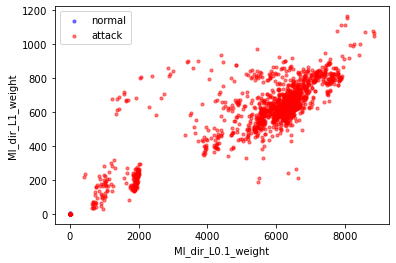

In [4]:
plot_n = 2000
atk = df_attack.sample(n=plot_n, random_state=76)
nrm = x_train.sample(n=plot_n, random_state=42)

fig, ax1 = plt.subplots()

ax1.scatter(nrm['MI_dir_L0.1_weight'],nrm['MI_dir_L1_weight'],10,c='blue', label='normal',alpha=0.5)
ax1.scatter(atk['MI_dir_L0.1_weight'],atk['MI_dir_L1_weight'],10,c='red',label='attack',alpha=0.5)

plt.xlabel('MI_dir_L0.1_weight')
plt.ylabel('MI_dir_L1_weight')

plt.legend()
plt.show()

In [5]:
classes = ['benign','malicious']
scored = []
indices = {}
shps = {}

#classifying benign as true and attack as false
for cl in classes:
    indices[cl] = df_ben['class'] == cl    
    shps[cl] =  df_ben[indices[cl]].shape[0]
        
for col in df_ben.columns:
    if col == 'class':
        continue
    num = 0
    den = 0
    m = df_ben[col].mean()
    
    for cl in classes:
        num += (shps[cl] / df_ben.shape[0]) * (m - df_ben[indices[cl]][col].mean())**2
        den += (shps[cl] / df_ben.shape[0]) * df_ben[indices[cl]][col].var()
    score = {'feature': col, 'score': num / den}
    scored.append(score)
    #print(score)
scored.sort(key=lambda x: x['score'], reverse=True)
scored[:5]

[{'feature': 'MI_dir_L0.1_weight', 'score': 1.0478924858805367},
 {'feature': 'H_L0.1_weight', 'score': 1.0478924689266897},
 {'feature': 'MI_dir_L1_weight', 'score': 1.040497174164095},
 {'feature': 'H_L1_weight', 'score': 1.040497174164095},
 {'feature': 'MI_dir_L3_weight', 'score': 1.014610037336972}]

### Predicting Anomaly

In [6]:
class AnomalyModel:
    #initialize model
    def __init__(self, model, threshold, scaler):
        self.model = model
        self.threshold = threshold
        self.scaler = scaler

    #predict the outcome using treshold
    def predict(self, x):
        x_pred = self.model.predict(x)
        mse = np.mean(np.power(x - x_pred, 2), axis=1)
        y_pred = mse > self.threshold
        return y_pred.astype(int)
    
    #scale the classes
    def scale_predict_classes(self, x):
        x = self.scaler.transform(x)
        y_pred = self.predict(x)
        classes_arr = []
        for e in y_pred:
            el = [0,0]
            el[e] = 1
            classes_arr.append(el)
        print(classes_arr)

        return np.array(classes_arr)

### Model creation - Deep autoencoder

In [7]:
def deep_model(input_dim):
    inp = Input(shape=(input_dim,))
    encoder = Dense(int(math.ceil(0.75 * input_dim)), activation="tanh")(inp)
    encoder = Dense(int(math.ceil(0.5 * input_dim)), activation="tanh")(encoder)
    encoder = Dense(int(math.ceil(0.25 * input_dim)), activation="tanh")(encoder)
    decoder = Dense(int(math.ceil(0.5 * input_dim)), activation="tanh")(encoder)
    decoder = Dense(int(math.ceil(0.75 * input_dim)), activation="tanh")(decoder)
    decoder = Dense(input_dim)(decoder)
    return Model(inp, decoder)

### Fit model

In [8]:
top_n_features=115
fs = [it['feature'] for it in scored[:top_n_features]]
X_train = x_train[fs]
X_opt = x_opt[fs]
X_test = x_test[fs]
    
#standardize train and optimize data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_opt = scaler.transform(X_opt)
    
#call function to create the model
model = deep_model(top_n_features)
model.compile(loss="mean_squared_error", optimizer="adam")
cp = ModelCheckpoint(filepath=f"anomaly/anomaly{top_n_features}.h5",monitor='val_loss',save_best_only=True,verbose=0)

#Early Stopping function until val_loss is same for 5 epochs
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
start = time.time()  #time function to determine time taken by model
epochs = 100
    
#fit on train dataset
history = model.fit(X_train, X_train,
                    epochs=epochs,
                    validation_data=(X_opt, X_opt),
                    verbose=1,
                    callbacks=[cp, es])
    
end = time.time()
print('time:', end - start)
print(model.summary())    

Epoch 1/100
137/137 [==============================] - 11s 56ms/step - loss: 0.5833 - val_loss: 0.2574
Epoch 2/100
137/137 [==============================] - 1s 4ms/step - loss: 0.2000 - val_loss: 0.1942
Epoch 3/100
137/137 [==============================] - 1s 4ms/step - loss: 0.1541 - val_loss: 0.1654
Epoch 4/100
137/137 [==============================] - 1s 4ms/step - loss: 0.1179 - val_loss: 0.1433
Epoch 5/100
137/137 [==============================] - 1s 4ms/step - loss: 0.1114 - val_loss: 0.1277
Epoch 6/100
137/137 [==============================] - 1s 4ms/step - loss: 0.1254 - val_loss: 0.1153
Epoch 7/100
137/137 [==============================] - 1s 4ms/step - loss: 0.0937 - val_loss: 0.1020
Epoch 8/100
137/137 [==============================] - 1s 4ms/step - loss: 0.0767 - val_loss: 0.0940
Epoch 9/100
137/137 [==============================] - 1s 4ms/step - loss: 0.0752 - val_loss: 0.0861
Epoch 10/100
137/137 [==============================] - 1s 4ms/step - loss: 0.0612 - val_

### Predict train dataset

In [9]:
#use optimization dataset to predict and find mse for anomaly detection
x_opt_predictions = model.predict(X_opt)
mse = np.mean(np.power(X_opt - x_opt_predictions, 2), axis=1)
mean = mse.mean()
std = mse.std()
    
#sampling a benign dataset and adding a class malicious with 0
df_benign = pd.DataFrame(x_opt[fs], columns=fs)
df_benign['malicious'] = 0
    
#sampling a malicious dataset and adding a class malicious with 1
df_malicious = df_attack.sample(n=df_benign.shape[0], random_state=39)[fs]
df_malicious['malicious'] = 1
    
#combining benign and malicous dataset
df_combo = df_benign.append(df_malicious)
    
#X_opt with feature values
X_opt = df_combo.drop(columns=['malicious']).values
X_opt_scaled = scaler.transform(X_opt)

#Y_opt with target values
Y_opt = df_combo['malicious']
best_acc = 0
best_n = 0
#varying treshold and selecting the best model
print('Selecting n------------------')
for n in range(1,30):
    tr = mean + n * std
    m = AnomalyModel(model , tr, scaler)
    Y_pred = m.predict(X_opt_scaled)
    print(f'For n {n}')
    print('Accuracy')
    acc = accuracy_score(Y_opt, Y_pred)
    if acc > best_acc:
        best_acc = acc  #determining the best aaccuracy
        best_n = n
    print(acc)
    print('Precision',precision_score(Y_opt, Y_pred))
    print("Recall",recall_score(Y_opt, Y_pred))
    print('Confusion Matrix',confusion_matrix(Y_opt, Y_pred))
        
        #accs.append({'acc': acc, 'n': top_n_features, 'cm': confusion_matrix(Y_test, Y_pred)})

Selecting n------------------
For n 1
Accuracy
0.8709677419354839
Precision 0.9827329562369753
Recall 0.7552047586364676
Confusion Matrix [[4313   58]
 [1070 3301]]
For n 2
Accuracy
0.8732555479295355
Precision 0.9886193471099132
Recall 0.7552047586364676
Confusion Matrix [[4333   38]
 [1070 3301]]
For n 3
Accuracy
0.8742850606268588
Precision 0.9915865384615384
Recall 0.7549759780370625
Confusion Matrix [[4343   28]
 [1071 3300]]
For n 4
Accuracy
0.8750857927247769
Precision 0.993676603432701
Recall 0.7549759780370625
Confusion Matrix [[4350   21]
 [1071 3300]]
For n 5
Accuracy
0.8754289636238847
Precision 0.9945750452079566
Recall 0.7549759780370625
Confusion Matrix [[4353   18]
 [1071 3300]]
For n 6
Accuracy
0.8760009151223976
Precision 0.9960760639903411
Recall 0.7549759780370625
Confusion Matrix [[4358   13]
 [1071 3300]]
For n 7
Accuracy
0.8761153054221003
Precision 0.9963768115942029
Recall 0.7549759780370625
Confusion Matrix [[4359   12]
 [1071 3300]]
For n 8
Accuracy
0.8763440

### Test data

In [10]:
#Creating a test Data frame and training model with test data
df_benign = pd.DataFrame(X_test, columns=fs)
df_benign['malicious'] = 0
df_malicious = df_attack.sample(n=df_benign.shape[0], random_state=17)[fs]
df_malicious['malicious'] = 1
df2 = df_benign.append(df_malicious)
X_test = df2.drop(columns=['malicious']).values
X_test_scaled = scaler.transform(X_test)
Y_test = df2['malicious']
    
#using best n value for treshold determined using opotimization dataset
deep_tr = mean + best_n * std
m = AnomalyModel(model , tr, scaler)
Y_pred = m.predict(X_test_scaled)
print('Test-----------------')
print(f'best n {best_n}')
print("Threshold ",tr)
deep_acc = accuracy_score(Y_test, Y_pred)
deep_precision = precision_score(Y_test, Y_pred)
deep_recall = recall_score(Y_test, Y_pred)
deep_cm = confusion_matrix(Y_test, Y_pred)
print('Accuracy ',deep_acc)
print('Precision ',deep_precision)
print("Recall",deep_recall)
print('Confusion Matrix',deep_cm)
   
#print(accs)

Test-----------------
best n 28
Threshold  7.645269247916332
Accuracy  0.880576527110501
Precision  1.0
Recall 0.7611530542210021
Confusion Matrix [[4371    0]
 [1044 3327]]


### Variational Autoencoder

In [11]:
def vae_model(input_dim):
    original_dim = input_dim
    intermediate_dim = 64
    latent_dim = 2

    inputs = Input(shape=(original_dim,))
    h = Dense(intermediate_dim, activation='relu')(inputs)
    z_mean = Dense(latent_dim)(h)
    z_log_sigma = Dense(latent_dim)(h)
    
    from keras import backend as K

    def sampling(args):
        z_mean, z_log_sigma = args
        epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=0.1)
        return z_mean + K.exp(z_log_sigma) * epsilon

    z = Lambda(sampling)([z_mean, z_log_sigma])

    # Create encoder
    encoder = Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

    # Create decoder
    latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
    x = Dense(intermediate_dim, activation='relu')(latent_inputs)
    outputs = Dense(original_dim, activation='sigmoid')(x)
    decoder = Model(latent_inputs, outputs, name='decoder')

    # instantiate VAE model
    outputs = decoder(encoder(inputs)[2])
    return Model(inputs, outputs, name='vae_mlp')


In [12]:
top_n_features=115
fs = [it['feature'] for it in scored[:top_n_features]]
X_train = x_train[fs]
X_opt = x_opt[fs]
X_test = x_test[fs]
    
#standardize train and optimize data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_opt = scaler.transform(X_opt)
    
#call function to create the model
model = vae_model(top_n_features)
model.compile(loss="mean_squared_error", optimizer="adam")
cp = ModelCheckpoint(filepath=f"anomaly/anomaly_vae.h5",monitor='val_loss',
                     save_best_only=True,save_weights_only=True,verbose=0)

#Early Stopping function until val_loss is same for 5 epochs
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
start = time.time()  #time function to determine time taken by model
epochs = 100
    
#fit on train dataset
history = model.fit(X_train, X_train,
                    epochs=epochs, validation_data=(X_opt, X_opt),
                    verbose=1, callbacks=[cp, es])
    
end = time.time()
print('time:', end - start)
print(model.summary()) 

Epoch 1/100
137/137 [==============================] - 3s 8ms/step - loss: 1.0536 - val_loss: 0.7376
Epoch 2/100
137/137 [==============================] - 1s 4ms/step - loss: 0.7332 - val_loss: 0.7269
Epoch 3/100
137/137 [==============================] - 1s 4ms/step - loss: 0.7446 - val_loss: 0.7226
Epoch 4/100
137/137 [==============================] - 0s 4ms/step - loss: 0.7107 - val_loss: 0.7203
Epoch 5/100
137/137 [==============================] - 1s 4ms/step - loss: 0.6737 - val_loss: 0.7164
Epoch 6/100
137/137 [==============================] - 1s 4ms/step - loss: 0.6675 - val_loss: 0.7147
Epoch 7/100
137/137 [==============================] - 1s 4ms/step - loss: 0.7026 - val_loss: 0.7129
Epoch 8/100
137/137 [==============================] - 1s 4ms/step - loss: 0.7091 - val_loss: 0.7115
Epoch 9/100
137/137 [==============================] - 0s 4ms/step - loss: 0.6898 - val_loss: 0.7106
Epoch 10/100
137/137 [==============================] - 1s 4ms/step - loss: 0.7259 - val_lo

### Train

In [13]:
#use optimization dataset to predict and find mse for anomaly detection
x_opt_predictions = model.predict(X_opt)
mse = np.mean(np.power(X_opt - x_opt_predictions, 2), axis=1)
mean = mse.mean()
std = mse.std()
    
#sampling a benign dataset and adding a class malicious with 0
df_benign = pd.DataFrame(x_opt[fs], columns=fs)
df_benign['malicious'] = 0
    
#sampling a malicious dataset and adding a class malicious with 1
df_malicious = df_attack.sample(n=df_benign.shape[0], random_state=39)[fs]
df_malicious['malicious'] = 1
    
#combining benign and malicous dataset
df_combo = df_benign.append(df_malicious)
    
#X_opt with feature values
X_opt = df_combo.drop(columns=['malicious']).values
X_opt_scaled = scaler.transform(X_opt)

#Y_opt with target values
Y_opt = df_combo['malicious']
best_acc = 0
best_n = 0
#varying treshold and selecting the best model
print('Selecting n------------------')
for n in range(1,30):
    tr = mean + n * std
    m = AnomalyModel(model , tr, scaler)
    Y_pred = m.predict(X_opt_scaled)
    print(f'For n {n}')
    print('Accuracy')
    acc = accuracy_score(Y_opt, Y_pred)
    if acc > best_acc:
        best_acc = acc  #determining the best aaccuracy
        best_n = n
    print(acc)
    print('Precision',precision_score(Y_opt, Y_pred))
    print("Recall",recall_score(Y_opt, Y_pred))
    print('Confusion Matrix',confusion_matrix(Y_opt, Y_pred))
        

Selecting n------------------
For n 1
Accuracy
0.9876458476321208
Precision 0.9758874748827864
Recall 1.0
Confusion Matrix [[4263  108]
 [   0 4371]]
For n 2
Accuracy
0.9932509723175474
Precision 0.9869015356820234
Recall 0.9997712194005949
Confusion Matrix [[4313   58]
 [   1 4370]]
For n 3
Accuracy
0.9958819492107069
Precision 0.9920544835414302
Recall 0.9997712194005949
Confusion Matrix [[4336   35]
 [   1 4370]]
For n 4
Accuracy
0.9962251201098147
Precision 0.9927305770104498
Recall 0.9997712194005949
Confusion Matrix [[4339   32]
 [   1 4370]]
For n 5
Accuracy
0.996682681308625
Precision 0.9936334697589814
Recall 0.9997712194005949
Confusion Matrix [[4343   28]
 [   1 4370]]
For n 6
Accuracy
0.9970258522077328
Precision 0.9943117178612059
Recall 0.9997712194005949
Confusion Matrix [[4346   25]
 [   1 4370]]
For n 7
Accuracy
0.997254632807138
Precision 0.9947643979057592
Recall 0.9997712194005949
Confusion Matrix [[4348   23]
 [   1 4370]]
For n 8
Accuracy
0.9978265843056509
Precis

### Test

In [14]:
#Creating a test Data frame and training model with test data
df_benign = pd.DataFrame(X_test, columns=fs)
df_benign['malicious'] = 0
df_malicious = df_attack.sample(n=df_benign.shape[0], random_state=17)[fs]
df_malicious['malicious'] = 1
df2 = df_benign.append(df_malicious)
X_test = df2.drop(columns=['malicious']).values
X_test_scaled = scaler.transform(X_test)
Y_test = df2['malicious']
    
#using best n value for treshold determined using opotimization dataset
tr = mean + best_n * std
m = AnomalyModel(model , tr, scaler)
Y_pred = m.predict(X_test_scaled)
print('Test-----------------')
print(f'best n {best_n}')
print("Threshold ",tr)
vae_acc = accuracy_score(Y_test, Y_pred)
vae_precision = precision_score(Y_test, Y_pred)
vae_recall = recall_score(Y_test, Y_pred)
vae_cm = confusion_matrix(Y_test, Y_pred)
print('Accuracy ',vae_acc)
print('Precision ',vae_precision)
print("Recall",vae_recall)
print('Confusion Matrix',vae_cm)

Test-----------------
best n 8
Threshold  16.592289127460308
Accuracy  0.9983985358041638
Precision  0.9968072976054732
Recall 1.0
Confusion Matrix [[4357   14]
 [   0 4371]]


### Undercomplete Autoencoder

In [15]:
def uc_model(input_dim):
    input_img = Input(shape=(input_dim,))
    encoded = Dense(15, activation='relu')(input_img)
    decoded = Dense(input_dim, activation='sigmoid')(encoded)

    autoencoder = Model(input_img, decoded)
    return autoencoder

In [16]:
top_n_features=115
fs = [it['feature'] for it in scored[:top_n_features]]
X_train = x_train[fs]
X_opt = x_opt[fs]
X_test = x_test[fs]
    
#standardize train and optimize data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_opt = scaler.transform(X_opt)
    
#call function to create the model
model = uc_model(top_n_features)
model.compile(loss="mean_squared_error", optimizer="adam")
cp = ModelCheckpoint(filepath=f"anomaly/anomaly_undercomplete.h5",monitor='val_loss',
                     save_best_only=True,save_weights_only=True,verbose=0)

#Early Stopping function until val_loss is same for 5 epochs
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
start = time.time()  #time function to determine time taken by model
epochs = 100
    
#fit on train dataset
history = model.fit(X_train, X_train,
                    epochs=epochs, validation_data=(X_opt, X_opt),
                    verbose=1, callbacks=[cp, es])
    
end = time.time()
print('time:', end - start)
print(model.summary()) 

Epoch 1/100
137/137 [==============================] - 2s 6ms/step - loss: 1.1272 - val_loss: 0.7674
Epoch 2/100
137/137 [==============================] - 0s 3ms/step - loss: 0.6932 - val_loss: 0.7297
Epoch 3/100
137/137 [==============================] - 1s 4ms/step - loss: 0.7579 - val_loss: 0.7142
Epoch 4/100
137/137 [==============================] - 1s 4ms/step - loss: 0.7166 - val_loss: 0.7044
Epoch 5/100
137/137 [==============================] - 0s 3ms/step - loss: 0.7711 - val_loss: 0.6970
Epoch 6/100
137/137 [==============================] - 0s 3ms/step - loss: 0.6681 - val_loss: 0.6911
Epoch 7/100
137/137 [==============================] - 0s 3ms/step - loss: 0.6721 - val_loss: 0.6871
Epoch 8/100
137/137 [==============================] - 1s 4ms/step - loss: 0.6735 - val_loss: 0.6835
Epoch 9/100
137/137 [==============================] - 1s 4ms/step - loss: 0.6861 - val_loss: 0.6802
Epoch 10/100
137/137 [==============================] - 1s 4ms/step - loss: 0.6836 - val_lo

In [17]:
#use optimization dataset to predict and find mse for anomaly detection
x_opt_predictions = model.predict(X_opt)
mse = np.mean(np.power(X_opt - x_opt_predictions, 2), axis=1)
mean = mse.mean()
std = mse.std()
    
#sampling a benign dataset and adding a class malicious with 0
df_benign = pd.DataFrame(x_opt[fs], columns=fs)
df_benign['malicious'] = 0
    
#sampling a malicious dataset and adding a class malicious with 1
df_malicious = df_attack.sample(n=df_benign.shape[0], random_state=39)[fs]
df_malicious['malicious'] = 1
    
#combining benign and malicous dataset
df_combo = df_benign.append(df_malicious)
    
#X_opt with feature values
X_opt = df_combo.drop(columns=['malicious']).values
X_opt_scaled = scaler.transform(X_opt)

#Y_opt with target values
Y_opt = df_combo['malicious']
best_acc = 0
best_n = 0
#varying treshold and selecting the best model
print('Selecting n------------------')
for n in range(1,30):
    tr = mean + n * std
    m = AnomalyModel(model , tr, scaler)
    Y_pred = m.predict(X_opt_scaled)
    print(f'For n {n}')
    print('Accuracy')
    acc = accuracy_score(Y_opt, Y_pred)
    if acc > best_acc:
        best_acc = acc  #determining the best aaccuracy
        best_n = n
    print(acc)
    print('Precision',precision_score(Y_opt, Y_pred))
    print("Recall",recall_score(Y_opt, Y_pred))
    print('Confusion Matrix',confusion_matrix(Y_opt, Y_pred))
        

Selecting n------------------
For n 1
Accuracy
0.9876458476321208
Precision 0.9758874748827864
Recall 1.0
Confusion Matrix [[4263  108]
 [   0 4371]]
For n 2
Accuracy
0.9930221917181423
Precision 0.9864559819413092
Recall 0.9997712194005949
Confusion Matrix [[4311   60]
 [   1 4370]]
For n 3
Accuracy
0.9956531686113017
Precision 0.9916042659405492
Recall 0.9997712194005949
Confusion Matrix [[4334   37]
 [   1 4370]]
For n 4
Accuracy
0.9963395104095173
Precision 0.9929561463303794
Recall 0.9997712194005949
Confusion Matrix [[4340   31]
 [   1 4370]]
For n 5
Accuracy
0.996682681308625
Precision 0.9936334697589814
Recall 0.9997712194005949
Confusion Matrix [[4343   28]
 [   1 4370]]
For n 6
Accuracy
0.9970258522077328
Precision 0.9943117178612059
Recall 0.9997712194005949
Confusion Matrix [[4346   25]
 [   1 4370]]
For n 7
Accuracy
0.9973690231068405
Precision 0.9949908925318761
Recall 0.9997712194005949
Confusion Matrix [[4349   22]
 [   1 4370]]
For n 8
Accuracy
0.8757721345229924
Preci

In [18]:
#Creating a test Data frame and training model with test data
df_benign = pd.DataFrame(X_test, columns=fs)
df_benign['malicious'] = 0
df_malicious = df_attack.sample(n=df_benign.shape[0], random_state=17)[fs]
df_malicious['malicious'] = 1
df2 = df_benign.append(df_malicious)
X_test = df2.drop(columns=['malicious']).values
X_test_scaled = scaler.transform(X_test)
Y_test = df2['malicious']
    
#using best n value for treshold determined using opotimization dataset
tr = mean + best_n * std
m = AnomalyModel(model , tr, scaler)
Y_pred = m.predict(X_test_scaled)
print('Test-----------------')
print(f'best n {best_n}')
print("Threshold ",tr)
uc_acc = accuracy_score(Y_test, Y_pred)
uc_precision = precision_score(Y_test, Y_pred)
uc_recall = recall_score(Y_test, Y_pred)
uc_cm = confusion_matrix(Y_test, Y_pred)
print('Accuracy ',uc_acc)
print('Precision ',uc_precision)
print("Recall",uc_recall)
print('Confusion Matrix',uc_cm)

Test-----------------
best n 7
Threshold  13.91239174152284
Accuracy  0.9978265843056509
Precision  0.9956719817767654
Recall 1.0
Confusion Matrix [[4352   19]
 [   0 4371]]


### Sparse Autoencoder

In [19]:
def sparse_model(input_dim):
    input_img = Input(shape=(input_dim,))
    encoded = Dense(200, activation='relu',
                activity_regularizer=regularizers.l1(10e-6))(input_img)
    decoded = Dense(input_dim, activation='sigmoid')(encoded)

    autoencoder = Model(input_img, decoded)
    return autoencoder

In [20]:
top_n_features=115
fs = [it['feature'] for it in scored[:top_n_features]]
X_train = x_train[fs]
X_opt = x_opt[fs]
X_test = x_test[fs]
    
#standardize train and optimize data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_opt = scaler.transform(X_opt)
    
#call function to create the model
model = sparse_model(top_n_features)
model.compile(loss="mean_squared_error", optimizer="adam")
cp = ModelCheckpoint(filepath=f"anomaly/anomaly_sparse.h5",monitor='val_loss',
                     save_best_only=True,save_weights_only=True,verbose=0)

#Early Stopping function until val_loss is same for 5 epochs
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
start = time.time()  #time function to determine time taken by model
epochs = 100
    
#fit on train dataset
history = model.fit(X_train, X_train,
                    epochs=epochs, validation_data=(X_opt, X_opt),
                    verbose=1, callbacks=[cp, es])
    
end = time.time()
print('time:', end - start)
print(model.summary()) 

Epoch 1/100
137/137 [==============================] - 2s 7ms/step - loss: 0.9102 - val_loss: 0.6902
Epoch 2/100
137/137 [==============================] - 0s 4ms/step - loss: 0.6765 - val_loss: 0.6702
Epoch 3/100
137/137 [==============================] - 1s 4ms/step - loss: 0.6651 - val_loss: 0.6626
Epoch 4/100
137/137 [==============================] - 1s 6ms/step - loss: 0.6432 - val_loss: 0.6586
Epoch 5/100
137/137 [==============================] - 1s 4ms/step - loss: 0.6776 - val_loss: 0.6568
Epoch 6/100
137/137 [==============================] - 1s 4ms/step - loss: 0.6437 - val_loss: 0.6555
Epoch 7/100
137/137 [==============================] - 1s 5ms/step - loss: 0.6780 - val_loss: 0.6547
Epoch 8/100
137/137 [==============================] - 1s 4ms/step - loss: 0.6646 - val_loss: 0.6539
Epoch 9/100
137/137 [==============================] - 1s 5ms/step - loss: 0.6271 - val_loss: 0.6534
Epoch 10/100
137/137 [==============================] - 1s 4ms/step - loss: 0.6195 - val_lo

In [21]:
#use optimization dataset to predict and find mse for anomaly detection
x_opt_predictions = model.predict(X_opt)
mse = np.mean(np.power(X_opt - x_opt_predictions, 2), axis=1)
mean = mse.mean()
std = mse.std()
    
#sampling a benign dataset and adding a class malicious with 0
df_benign = pd.DataFrame(x_opt[fs], columns=fs)
df_benign['malicious'] = 0
    
#sampling a malicious dataset and adding a class malicious with 1
df_malicious = df_attack.sample(n=df_benign.shape[0], random_state=39)[fs]
df_malicious['malicious'] = 1
    
#combining benign and malicous dataset
df_combo = df_benign.append(df_malicious)
    
#X_opt with feature values
X_opt = df_combo.drop(columns=['malicious']).values
X_opt_scaled = scaler.transform(X_opt)

#Y_opt with target values
Y_opt = df_combo['malicious']
best_acc = 0
best_n = 0
#varying treshold and selecting the best model
print('Selecting n------------------')
for n in range(1,30):
    tr = mean + n * std
    m = AnomalyModel(model , tr, scaler)
    Y_pred = m.predict(X_opt_scaled)
    print(f'For n {n}')
    print('Accuracy')
    acc = accuracy_score(Y_opt, Y_pred)
    if acc > best_acc:
        best_acc = acc  #determining the best aaccuracy
        best_n = n
    print(acc)
    print('Precision',precision_score(Y_opt, Y_pred))
    print("Recall",recall_score(Y_opt, Y_pred))
    print('Confusion Matrix',confusion_matrix(Y_opt, Y_pred))

Selecting n------------------
For n 1
Accuracy
0.9874170670327156
Precision 0.9754519080562375
Recall 1.0
Confusion Matrix [[4261  110]
 [   0 4371]]
For n 2
Accuracy
0.9929078014184397
Precision 0.9862333559016023
Recall 0.9997712194005949
Confusion Matrix [[4310   61]
 [   1 4370]]
For n 3
Accuracy
0.9956531686113017
Precision 0.9916042659405492
Recall 0.9997712194005949
Confusion Matrix [[4334   37]
 [   1 4370]]
For n 4
Accuracy
0.9963395104095173
Precision 0.9929561463303794
Recall 0.9997712194005949
Confusion Matrix [[4340   31]
 [   1 4370]]
For n 5
Accuracy
0.996682681308625
Precision 0.9936334697589814
Recall 0.9997712194005949
Confusion Matrix [[4343   28]
 [   1 4370]]
For n 6
Accuracy
0.9970258522077328
Precision 0.9943117178612059
Recall 0.9997712194005949
Confusion Matrix [[4346   25]
 [   1 4370]]
For n 7
Accuracy
0.9973690231068405
Precision 0.9949908925318761
Recall 0.9997712194005949
Confusion Matrix [[4349   22]
 [   1 4370]]
For n 8
Accuracy
0.9980553649050561
Preci

In [22]:
#Creating a test Data frame and training model with test data
df_benign = pd.DataFrame(X_test, columns=fs)
df_benign['malicious'] = 0
df_malicious = df_attack.sample(n=df_benign.shape[0], random_state=17)[fs]
df_malicious['malicious'] = 1
df2 = df_benign.append(df_malicious)
X_test = df2.drop(columns=['malicious']).values
X_test_scaled = scaler.transform(X_test)
Y_test = df2['malicious']
    
#using best n value for treshold determined using opotimization dataset
tr = mean + best_n * std
m = AnomalyModel(model , tr, scaler)
Y_pred = m.predict(X_test_scaled)
print('Test-----------------')
print(f'best n {best_n}')
print("Threshold ",tr)
sparse_acc = accuracy_score(Y_test, Y_pred)
sparse_precision = precision_score(Y_test, Y_pred)
sparse_recall = recall_score(Y_test, Y_pred)
sparse_cm = confusion_matrix(Y_test, Y_pred)
print('Accuracy ',sparse_acc)
print('Precision ',sparse_precision)
print("Recall",sparse_recall)
print('Confusion Matrix',sparse_cm)

Test-----------------
best n 8
Threshold  15.693549062077409
Accuracy  0.9985129261038664
Precision  0.9970346715328468
Recall 1.0
Confusion Matrix [[4358   13]
 [   0 4371]]


### Denoising Autoencoder

In [23]:
def denoise_model(input_dim):
    input_size = input_dim
    hidden_size = 44
    code_size = 5

    input_img = Input(shape=(input_size,))
    hidden_1 = Dense(hidden_size, activation='relu')(input_img)
    code = Dense(code_size, activation='relu')(hidden_1)
    hidden_2 = Dense(hidden_size, activation='relu')(code)
    output_img = Dense(input_size, activation='sigmoid')(hidden_2)

    autoencoder = Model(input_img, output_img)
    return autoencoder

In [24]:
top_n_features=115
fs = [it['feature'] for it in scored[:top_n_features]]
X_train = x_train[fs]
X_opt = x_opt[fs]
X_test = x_test[fs]
    
#standardize train and optimize data
scaler = StandardScaler()

noise_factor = 0.5
x_train_noisy = X_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape) 
x_test_noisy = X_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_test.shape) 
x_opt_noisy = X_opt + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_opt.shape) 
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)
x_opt_noisy = np.clip(x_opt_noisy, 0., 1.)

X_train = scaler.fit_transform(X_train)
X_opt = scaler.transform(X_opt)
#x_train_noisy = scaler.fit_transform(x_train_noisy)
#x_opt_noisy = scaler.transform(x_opt_noisy)

#call function to create the model
model = denoise_model(top_n_features)
model.compile(loss="mean_squared_error", optimizer="adam")
cp = ModelCheckpoint(filepath=f"anomaly/anomaly_sparse.h5",monitor='val_loss',
                     save_best_only=True,save_weights_only=True,verbose=0)

#Early Stopping function until val_loss is same for 5 epochs
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
start = time.time()  #time function to determine time taken by model
epochs = 100
    
#fit on train dataset
history = model.fit(x_train_noisy, X_train,
                    epochs=epochs, validation_data=(x_opt_noisy, X_opt),
                    verbose=1, callbacks=[cp, es])
    
end = time.time()
print('time:', end - start)
print(model.summary()) 

Epoch 1/100
137/137 [==============================] - 2s 8ms/step - loss: 1.1504 - val_loss: 1.0035
Epoch 2/100
137/137 [==============================] - 1s 5ms/step - loss: 0.9991 - val_loss: 0.8401
Epoch 3/100
137/137 [==============================] - 1s 5ms/step - loss: 0.8275 - val_loss: 0.7957
Epoch 4/100
137/137 [==============================] - 1s 5ms/step - loss: 0.8269 - val_loss: 0.7925
Epoch 5/100
137/137 [==============================] - 1s 6ms/step - loss: 0.8275 - val_loss: 0.7900
Epoch 6/100
137/137 [==============================] - 1s 5ms/step - loss: 0.7559 - val_loss: 0.7885
Epoch 7/100
137/137 [==============================] - 1s 5ms/step - loss: 0.7595 - val_loss: 0.7869
Epoch 8/100
137/137 [==============================] - 1s 4ms/step - loss: 0.8100 - val_loss: 0.7851
Epoch 9/100
137/137 [==============================] - 1s 5ms/step - loss: 0.7849 - val_loss: 0.7822
Epoch 10/100
137/137 [==============================] - 1s 6ms/step - loss: 0.7520 - val_lo

In [25]:
#use optimization dataset to predict and find mse for anomaly detection
x_opt_predictions = model.predict(x_opt_noisy)
mse = np.mean(np.power(x_opt_noisy - x_opt_predictions, 2), axis=1)
mean = mse.mean()
std = mse.std()
    
#sampling a benign dataset and adding a class malicious with 0
df_benign = pd.DataFrame(x_opt[fs], columns=fs)
df_benign['malicious'] = 0
    
#sampling a malicious dataset and adding a class malicious with 1
df_malicious = df_attack.sample(n=df_benign.shape[0], random_state=39)[fs]
df_malicious['malicious'] = 1
    
#combining benign and malicous dataset
df_combo = df_benign.append(df_malicious)
    
#X_opt with feature values
X_opt = df_combo.drop(columns=['malicious']).values
x_opt_noisy = X_opt + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_opt.shape) 
X_opt_scaled = scaler.transform(x_opt_noisy)

#Y_opt with target values
Y_opt = df_combo['malicious']
best_acc = 0
best_n = 0
#varying treshold and selecting the best model
print('Selecting n------------------')
for n in range(1,30):
    tr = mean + n * std
    m = AnomalyModel(model , tr, scaler)
    Y_pred = m.predict(X_opt_scaled)
    print(f'For n {n}')
    print('Accuracy')
    acc = accuracy_score(Y_opt, Y_pred)
    if acc > best_acc:
        best_acc = acc  #determining the best aaccuracy
        best_n = n
    print(acc)
    print('Precision',precision_score(Y_opt, Y_pred))
    print("Recall",recall_score(Y_opt, Y_pred))
    print('Confusion Matrix',confusion_matrix(Y_opt, Y_pred))

Selecting n------------------
For n 1
Accuracy
0.5001143902997026
Precision 0.5000572016931701
Recall 1.0
Confusion Matrix [[   1 4370]
 [   0 4371]]
For n 2
Accuracy
0.5009151223976207
Precision 0.5004579803068469
Recall 1.0
Confusion Matrix [[   8 4363]
 [   0 4371]]
For n 3
Accuracy
0.5022878059940517
Precision 0.5011465260261408
Recall 1.0
Confusion Matrix [[  20 4351]
 [   0 4371]]
For n 4
Accuracy
0.5082361015785861
Precision 0.504152249134948
Recall 1.0
Confusion Matrix [[  72 4299]
 [   0 4371]]
For n 5
Accuracy
0.5161290322580645
Precision 0.5081967213114754
Recall 1.0
Confusion Matrix [[ 141 4230]
 [   0 4371]]
For n 6
Accuracy
0.5277968428277282
Precision 0.5142957995058243
Recall 1.0
Confusion Matrix [[ 243 4128]
 [   0 4371]]
For n 7
Accuracy
0.543010752688172
Precision 0.5224719101123596
Recall 1.0
Confusion Matrix [[ 376 3995]
 [   0 4371]]
For n 8
Accuracy
0.5626858842370167
Precision 0.5334391017817915
Recall 1.0
Confusion Matrix [[ 548 3823]
 [   0 4371]]
For n 9
Accu

In [26]:
#Creating a test Data frame and training model with test data
df_benign = pd.DataFrame(x_test_noisy, columns=fs)
df_benign['malicious'] = 0
df_malicious = df_attack.sample(n=df_benign.shape[0], random_state=20)[fs]
df_malicious['malicious'] = 1
df2 = df_benign.append(df_malicious)
X_test = df2.drop(columns=['malicious']).values
x_test_noisy = X_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_test.shape) 
X_test_scaled = scaler.transform(x_test_noisy)
Y_test = df2['malicious']
    
#using best n value for treshold determined using opotimization dataset
tr = mean + best_n * std
m = AnomalyModel(model , tr, scaler)
Y_pred = m.predict(X_test_scaled)
print('Test-----------------')
print(f'best n {best_n}')
print("Threshold ",tr)
denoise_acc = accuracy_score(Y_test, Y_pred)
denoise_precision = precision_score(Y_test, Y_pred)
denoise_recall = recall_score(Y_test, Y_pred)
denoise_cm = confusion_matrix(Y_test, Y_pred)
print('Accuracy ',denoise_acc)
print('Precision ',denoise_precision)
print("Recall",denoise_recall)
print('Confusion Matrix',denoise_cm)

Test-----------------
best n 29
Threshold  3.922659487657792
Accuracy  0.5235644017387325
Precision  0.512066541705717
Recall 1.0
Confusion Matrix [[ 206 4165]
 [   0 4371]]


### Deep Neural Net

In [27]:
def dnn_model(inputs):
    model = Sequential()
    model.add(Dense(115, input_dim=inputs, activation='relu'))
    model.add(Dense(80, input_dim=inputs, activation='relu'))
    model.add(Dense(10, input_dim=inputs, activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.add(Dense(labels.shape[1],activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    es = EarlyStopping(monitor='val_loss', min_delta=1e-3, callbacks=[monitor], patience=5) 
    model.fit(x_train_st,y_train_st,validation_data=(x_test_st,y_test_st),
          verbose=1,epochs=100, callbacks=[es])

In [28]:
df_attack = df_mirai.append(df_gafgyt)
df_attack['class'] = 1

df_ben = x_train.copy()
df_ben['class'] = 0

df_ben = df_ben.append(df_attack.sample(n=df_ben.shape[0], random_state=17))

X = df_ben.drop(columns=['class'])
y = df_ben['class']

In [29]:
#split train and test data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,random_state=17)

#scale data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)


In [30]:
#create model
model = Sequential()
model.add(Dense(115, input_dim=115, activation='relu'))
model.add(Dense(80, activation='relu'))
model.add(Dense(30, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
start = time.time()  #time function to determine time taken by model
epochs = 100

#compile and fit model
model.compile(loss="mean_squared_error", optimizer="adam")
model.fit(X_train,y_train,epochs=epochs,batch_size=15,callbacks=[es])

end = time.time()
print("time",end-start)

Epoch 1/100
467/467 [==============================] - 2s 2ms/step - loss: 0.0115
Epoch 2/100
467/467 [==============================] - 1s 2ms/step - loss: 7.1540e-04
Epoch 3/100
467/467 [==============================] - 1s 2ms/step - loss: 7.4876e-04
Epoch 4/100
467/467 [==============================] - 1s 2ms/step - loss: 4.4497e-04
Epoch 5/100
467/467 [==============================] - 1s 2ms/step - loss: 0.0016
Epoch 6/100
467/467 [==============================] - 1s 2ms/step - loss: 8.4631e-04
Epoch 7/100
467/467 [==============================] - 1s 2ms/step - loss: 2.0603e-04
Epoch 8/100
467/467 [==============================] - 1s 2ms/step - loss: 7.6586e-04
Epoch 9/100
467/467 [==============================] - 1s 2ms/step - loss: 9.3373e-05
Epoch 10/100
467/467 [==============================] - 1s 2ms/step - loss: 9.9690e-04
Epoch 11/100
467/467 [==============================] - 1s 2ms/step - loss: 5.0171e-05
Epoch 12/100
467/467 [==============================] - 1s 2

In [31]:
predictions = model.predict(X_test)
y_pred = [round(x[0]) for x in predictions]

In [32]:
dnn_acc = accuracy_score(y_test, y_pred)
dnn_precision = precision_score(y_test, y_pred)
dnn_recall = recall_score(y_test, y_pred)
dnn_cm = confusion_matrix(y_test, y_pred)
print('Accuracy ',dnn_acc)
print('Precision ',dnn_precision)
print("Recall",dnn_recall)
print('Confusion Matrix',dnn_cm)

Accuracy  0.9948542024013722
Precision  0.9965277777777778
Recall 0.9930795847750865
Confusion Matrix [[879   3]
 [  6 861]]


### Model comparison

In [33]:
print("Thermostat")
model_summary = pd.DataFrame({'Model' :['Deep AutoEncoder',"Variational AutoEncoder","Sparse AutoEncoder","Undercomplete Autoencoder","Denoising Autoendoer"],
                             'Accuracy':[deep_acc,vae_acc,sparse_acc,uc_acc,denoise_acc],
                             'Precision':[deep_precision,vae_precision,sparse_precision,uc_precision,denoise_precision],
                             'Recall':[deep_recall,vae_recall,sparse_recall,uc_recall,denoise_recall],
                             'CM':[deep_cm,vae_cm,sparse_cm,uc_cm, denoise_cm]})
model_summary.sort_values(by='Accuracy', ascending=True)

Thermostat


,Model,Accuracy,Precision,Recall,CM
4,Denoising Autoendoer,0.523564,0.512067,1.000000,"[[206, 4165], [0, 4371]]"
0,Deep AutoEncoder,0.880577,1.000000,0.761153,"[[4371, 0], [1044, 3327]]"
3,Undercomplete Autoencoder,0.997827,0.995672,1.000000,"[[4352, 19], [0, 4371]]"
1,Variational AutoEncoder,0.998399,0.996807,1.000000,"[[4357, 14], [0, 4371]]"
2,Sparse AutoEncoder,0.998513,0.997035,1.000000,"[[4358, 13], [0, 4371]]"
